In [24]:
using CSV, DataFrames, Statistics, Random, Plots, JuMP, Gurobi, Distributions, Random, Metrics

#import sklearn functions 
using ScikitLearn
@sk_import linear_model: LogisticRegression
@sk_import linear_model: LinearRegression
@sk_import metrics:accuracy_score;
@sk_import metrics:precision_score;
@sk_import metrics:recall_score;
@sk_import metrics:mean_squared_error;

#import own functions
include("utils.jl")

check_accuracy (generic function with 1 method)

### Helper functions

In [25]:
function generate_covariate_shift(X_test)
    #set a seed for distribution
    Random.seed!(123)

    col_means = mean(Matrix(X_test), dims=1)
    std_dev = 0.1

    random_values = zeros(size(X_test))
    for col_index in 1:size(X_test, 2)
        col_mean = col_means[col_index]
        col_shift = rand(Normal(col_mean * 0.4 , std_dev), (size(X_test, 1), 1))
        random_values[:, col_index] = col_shift
    end

    X_test_shift = Matrix(X_test) .+ random_values;
    df_X_test_shift = DataFrame(X_test_shift,Symbol.(names(X_test)))
    return df_X_test_shift
end

generate_covariate_shift (generic function with 1 method)

In [26]:
function plot_covariate_shit(X_train, X_test_shift)
    plot_list = []
    num_cols = 2

    for (i, col) in enumerate(names(X_train))
        # Create density plots
        p = histogram(X_train[:, col], label="X_train", alpha=0.7, nbins=20,title=string("Column: ", col))
        histogram!(X_test_shift[:, col], label="X_test", alpha=0.7, nbins=20)
        
        push!(plot_list, p)
    end

    plot(plot_list..., layout=(length(plot_list) ÷ num_cols + 1, num_cols), legend=true, size=(800, 800))

end


plot_covariate_shit (generic function with 1 method)

In [27]:
function check_accuracy(y_pred, y_true)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    println("accuracy: ", round(accuracy, digits=10))
    println("precision: ", round(precision, digits=10))
    println("recall: ", round(recall, digits=10))
    return 
end


check_accuracy (generic function with 1 method)

In [28]:
function LasssoRegression(X, y, lambda, weight = nothing)
    # add column of ones
    X = hcat(ones(Int, size(X, 1)), X)
    n, p = size(X)

    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, u[1:n])
    @variable(model, beta[1:p])
    @variable(model, w[1:p])

    @objective(model, Min, sum(u) + lambda * sum(w))

    for i in 1:p
        @constraint(model, w[i] >= beta[i])
        @constraint(model, w[i] >= -beta[i])
    end

    if weight !== nothing
        for i in 1:n
            @constraint(model, u[i] >= weight[i] * (y[i] - sum(X[i, :] .* beta)))
            @constraint(model, u[i] >= - weight[i] * (y[i] - sum(X[i, :] .* beta)))
        end
    else
        for i in 1:n
            @constraint(model, u[i] >= (y[i] - sum(X[i, :] .* beta)))
            @constraint(model, u[i] >=  - (y[i] - sum(X[i, :] .* beta)))
        end
    end

    optimize!(model)

    return value.(beta)
end


LasssoRegression (generic function with 2 methods)

In [29]:
function normalize_data(X_train, X_test)
    # Calculate mean and standard deviation from training data
    mean_vals = mean(X_train, dims=1)
    std_vals = std(X_train, dims=1)

    # Normalize training data
    X_train_norm = (X_train .-mean_vals) ./ std_vals;
    X_test_norm = (X_test .-mean_vals) ./ std_vals;

    return X_train_norm, X_test_norm
end

normalize_data (generic function with 1 method)

In [35]:
function compute_rmse(X_train, y_train, X_test, y_test, weight= nothing)
    if weight !== nothing
        # train a weighted model
        # lr = LinearRegression().fit(X_train, y_train, sample_weight = weight)
        # y_hat_train_weight = lr.predict(X_train)
        # y_hat_test_weight = lr.predict(X_test)

        betas = LasssoRegression(Matrix(X_train), y_train, 0, weights_shift)
        X_train = hcat(ones(Int, size(X_train, 1)), X_train)
        X_test = hcat(ones(Int, size(X_test, 1)), X_test)
        y_hat_train_weight = X_train * betas
        y_hat_test_weight = X_test * betas

        println("MSE with weights for train set:")
        println(mean_squared_error(y_train,y_hat_train_weight))
        println("")
        println("MSE with weights for test set:")
        println(mean_squared_error(y_test, y_hat_test_weight))
    else
        # train simple linear regression
        # lr = LinearRegression().fit(X_train, y_train)
        # y_hat_train = lr.predict(X_train)
        # y_hat_test = lr.predict(X_test)

        betas = LasssoRegression(Matrix(X_train), y_train, 0)
        X_train = hcat(ones(Int, size(X_train, 1)), X_train)
        X_test = hcat(ones(Int, size(X_test, 1)), X_test)
        y_hat_train = X_train * betas
        y_hat_test = X_test * betas
        
        println("MSE for train set:")
        println(mean_squared_error(y_train, y_hat_train))
        println("")
        println("MSE for test set:")
        println(mean_squared_error(y_test, y_hat_test))
    end
    return betas
end

compute_rmse (generic function with 2 methods)

### Try on synthetic data

In [19]:
X_train = CSV.read("../data/synthetic/X_test",header = false,DataFrame)
X_test_shift = CSV.read("../data/synthetic/X_train",header = false,DataFrame)
y_train = CSV.read("../data/synthetic/y_train",header = false,DataFrame)
y_train = transpose([y for y in Matrix(y_train)])
y_test = CSV.read("../data/synthetic/y_test",header = false,DataFrame)
y_test = transpose([y for y in Matrix(y_test)])
weights_ = CSV.read("../data/synthetic/weights",header = false,DataFrame)
weights_ = transpose([y for y in Matrix(weights_)]);

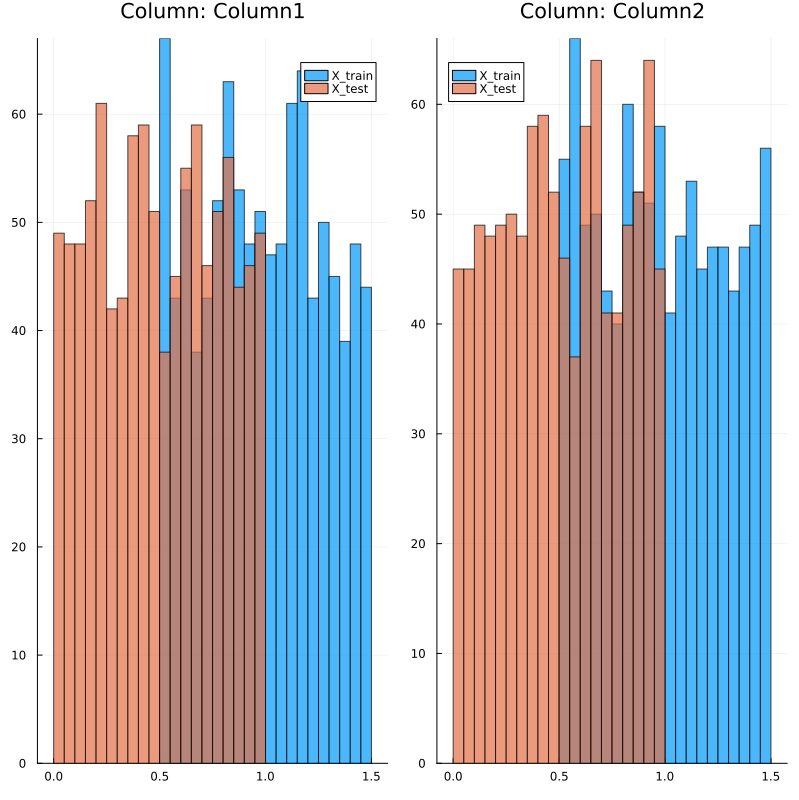

In [20]:
# X_test_shift = generate_covariate_shift(X_test)
plot_covariate_shit(X_train, X_test_shift)

In [21]:
weights_shift = get_weights(X_train, X_test_shift);

accuracy: 0.874
precision: 0.875502008
recall: 0.872


In [22]:
compute_rmse(Matrix(X_train), y_train, Matrix(X_test_shift), y_test, weights_shift)

MSE with weights for train set:
0.17703183292214036

MSE with weights for test set:
0.4671229580252922


PyObject LinearRegression()

In [23]:
compute_rmse(Matrix(X_train), y_train, Matrix(X_test_shift), y_test)

MSE for train set:
0.1754345518548831

MSE for test set:
0.4716872012557721


PyObject LinearRegression()

### Try on concrete data

- it works if the covariate shift is: col_mean * 0.2
    - MSE with weights for test set: 146.55001663891667
    - MSE for test set:232.7105130281361

In [39]:
X_full, y_full = get_concrete_data()

(X_train, y_train), (X_test, y_test) = 
IAI.split_data(:regression, X_full, y_full, train_proportion=0.9, seed = 209);

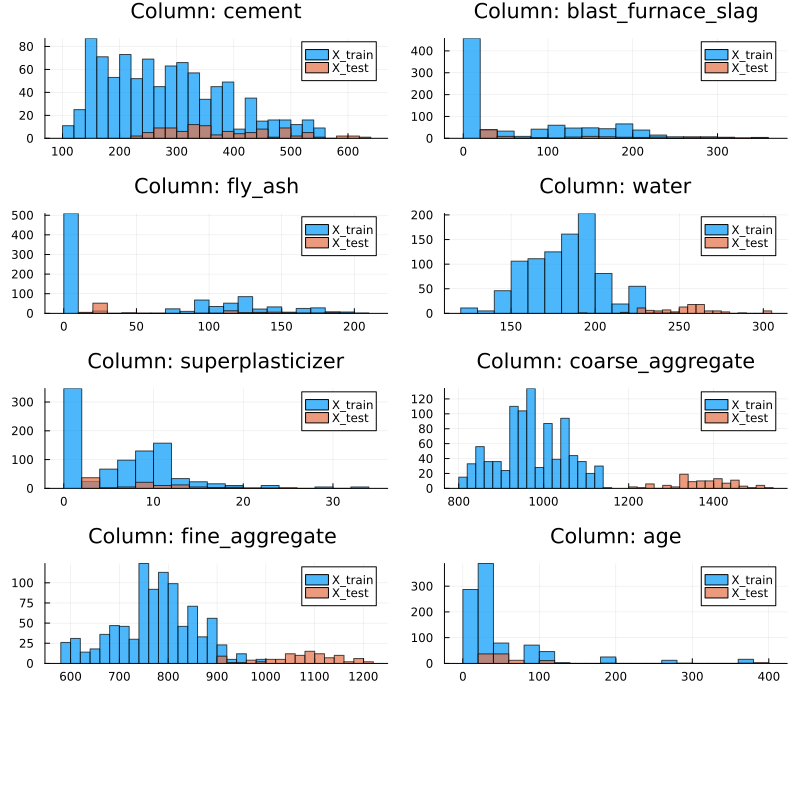

In [40]:
X_test_shift = generate_covariate_shift(X_test)
plot_covariate_shit(X_train, X_test_shift)

In [41]:
X_train_norm, X_test_shift_norm = normalize_data(Matrix(X_train), X_test_shift);

In [42]:
weights_shift = get_weights(X_train_norm, Matrix(X_test_shift_norm));

accuracy: 1.0
precision: 1.0
recall: 1.0


In [43]:
compute_rmse(Matrix(X_train_norm), y_train, Matrix(X_test_shift_norm), y_test, weights_shift)

MSE with weights for train set:
108.9543557117431

MSE with weights for test set:
145.4561551563275


PyObject LinearRegression()

In [44]:
compute_rmse(Matrix(X_train_norm), y_train, Matrix(X_test_shift_norm), y_test)

MSE for train set:
106.18210754652591

MSE for test set:
520.9873731349104


PyObject LinearRegression()

### Try on computer hardware

In [47]:
X_full, y_full = get_comp_hard_data()

(X_train, y_train), (X_test, y_test) = 
IAI.split_data(:regression, X_full, y_full, train_proportion=0.9, seed = 209);

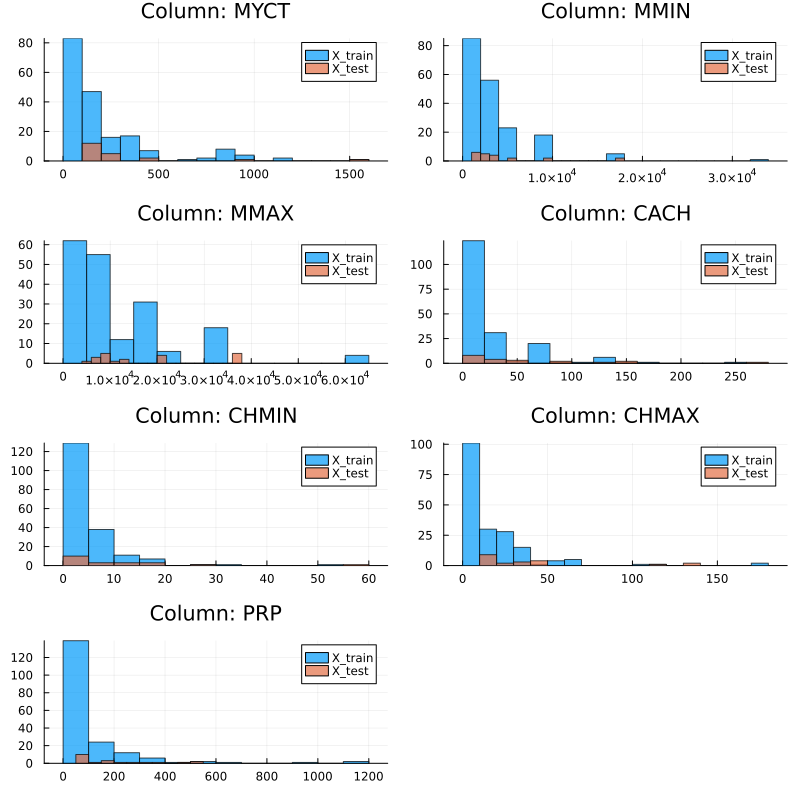

In [48]:
X_test_shift = generate_covariate_shift(X_test)
plot_covariate_shit(X_train, X_test_shift)

In [49]:
X_train_norm, X_test_shift_norm = normalize_data(Matrix(X_train), X_test_shift);
weights_shift = get_weights(X_train_norm, Matrix(X_test_shift_norm));

accuracy: 0.9138755981
precision: 0.8
recall: 0.1904761905


In [50]:
compute_rmse(Matrix(X_train_norm), y_train, Matrix(X_test_shift_norm), y_test, weights_shift)

MSE with weights for train set:
1136.3358454252877

MSE with weights for test set:
10075.575546757576


PyObject LinearRegression()

In [51]:
compute_rmse(Matrix(X_train_norm), y_train, Matrix(X_test_shift_norm), y_test)

MSE for train set:
875.9724780668395

MSE for test set:
7880.587506981053


PyObject LinearRegression()

### Try another covariate type 

- https://arxiv.org/pdf/1712.10043.pdf

In [61]:
using Random
using StatsBase
using MultivariateStats
using StatsBase: sample

function perform_pca(dataset)
    # train a PCA model,
    pca = fit(PCA, dataset'; maxoutdim=size(dataset, 2))
    # apply PCA model to data set
    pca_result = transpose(MultivariateStats.transform(pca, dataset'))
    return pca_result
end

perform_pca (generic function with 1 method)

In [62]:
function plot_covariate_shit(X_train, X_test_shift)
    plot_list = []
    num_cols = 2

    for (i, col) in enumerate(names(X_train))
        # Create density plots
        p = histogram(X_train[:, col], label="X_train", alpha=0.7, nbins=20,title=string("Column: ", col))
        histogram!(X_test_shift[:, col], label="X_test", alpha=0.7, nbins=20)
        
        push!(plot_list, p)
    end

    plot(plot_list..., layout=(length(plot_list) ÷ num_cols + 1, num_cols), legend=true, size=(800, 800))

end


plot_covariate_shit (generic function with 1 method)

In [63]:
function calculate_weight_vector(mi, a, b)
    mu_i = minimum(mi) + (maximum(mi) - minimum(mi)) / a
    sigma_i = std(mi) / b
    weight_vector = pdf.(Normal(mu_i, sigma_i), mi)
    return weight_vector
end

calculate_weight_vector (generic function with 1 method)

In [64]:
function biased_sampling(data, pca_result, a, b)
    num_samples = size(data, 1)

    # Randomly choose a principal component i
    i = rand(1:size(pca_result, 2))

    # Calculate weight vector
    weight_vector = calculate_weight_vector(pca_result[:, i], a, b)

    # Sample examples
    sampled_indices = sample(1:num_samples, Weights(weight_vector), num_samples, replace=true)

    return data[sampled_indices, :]
end

biased_sampling (generic function with 1 method)

In [99]:
X_full, y_full = get_concrete_data();
(X_train, y_train), (X_test, y_test) = 
IAI.split_data(:regression, X_full, y_full, train_proportion=0.5, seed = 209);

X_train_norm, X_test_norm = normalize_data(Matrix(X_train), Matrix(X_test));

In [112]:

function biased_sample(X_norm)
    lower_a = 0
    upper_a = 1/2
    lower_b = 1/2
    upper_b = 1

    pca_train_result = perform_pca(X_train_norm);
    pca_test_result = perform_pca(X_train_norm);

    a = rand(Uniform(lower_a, upper_a))
    b = rand(Uniform(lower_b, upper_b))

    # Step 5 and 6 for testing and training data
    biased_train_data = biased_sampling(X_train_norm, pca_train_result, a, b)
    biased_test_data = biased_sampling(X_train_norm, pca_test_result, a, b);

    return 

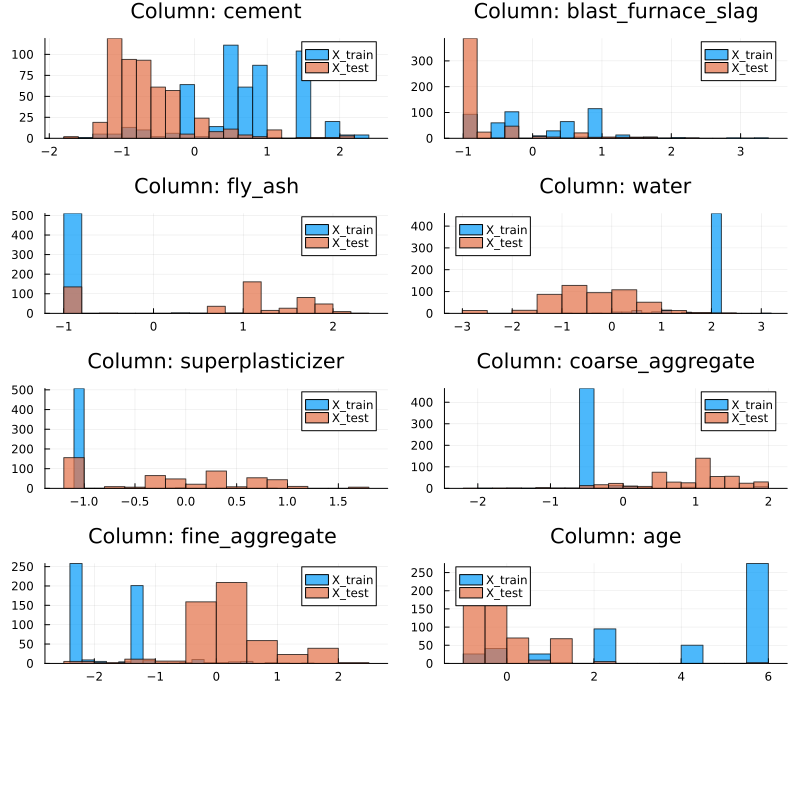

In [113]:
biased_train_df = DataFrame(biased_train_data, Symbol.(names(X_train)))
biased_test_df = DataFrame(biased_test_data, Symbol.(names(X_train)))

plot_covariate_shit(biased_train_df,biased_test_df)

In [105]:
weights_shift = get_weights(biased_train_data, biased_test_data, true);

accuracy: 1.0
precision: 1.0
recall: 1.0


In [106]:
compute_rmse(Matrix(biased_train_data), y_train, Matrix(biased_test_data), y_test, weights_shift);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
MSE with weights for train set:
277.93261537165785

MSE with weights for test set:
504331.4634501638


In [107]:
compute_rmse(Matrix(biased_train_data), y_train, Matrix(biased_test_data), y_test);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
MSE for train set:
277.72113631286294

MSE for test set:
534818.0375929448
